In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import thermo
from profiles import *
import utils

In [2]:
# Find the simulations
def findDirs(loadPath):
    labs = []; dirs  = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(loadPath):
        for direc in d:
            dname = os.path.join(r, direc)
            if 'run_' in direc and '-' not in direc and 'input' not in dname and 'oldruns' not in dname:
                labs.append(direc[4:])
                dirs.append(dname)
    sortst = [run for run in labs]
    sortst = list(map(int, sortst))
    order = sorted(range(len(sortst)), key=lambda x: sortst[x])
    labs = [int(labs[i]) for i in order]
    dirs = [dirs[i] for i in order]
    return labs, dirs

root_dir = '/vol0500/data/hp240116/fredrik/deep-botany/ensemble-3'
labs, dirs = findDirs(root_dir)

# Take only those that ran
# rmax = 3
# dirs = dirs[:rmax]
# labs = labs[:rmax]

member=xr.DataArray(data=labs, coords={'member':np.array(labs)})

In [3]:
# # Initial profiles
# fig, axs = plt.subplots(ncols=3,figsize=(15,5),sharey=True)

# for i in range(len(dirs)):
#     profi = np.loadtxt(dirs[i]+'/prof.inp.001')

#     axs[0].plot(profi[:,1], profi[:,0])
#     axs[1].plot(profi[:,2], profi[:,0])
#     axs[2].plot(profi[:,3], profi[:,0])

In [4]:
# Tmser
tmsers = [dirs[i]+'/tmser.001.nc' for i in range(len(dirs))]
ds_tm = xr.open_mfdataset(tmsers, combine='nested', concat_dim=member)
ds_tm

<xarray.Dataset> Size: 50MB
Dimensions:  (time: 3600, member: 82)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2024-08-01T00:01:00 ... 2024-08-03T12...
  * member   (member) int64 656B 0 1 2 3 4 5 6 7 8 ... 74 75 76 77 78 79 80 81
Data variables: (12/42)
    cfrac    (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    zb       (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    zc_av    (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    zc_max   (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    zi       (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    we       (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    ...       ...
    rsdtm    (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    rldtm    (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    rsutm    (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    rlutm    (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    rsutmcs  (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    rlutmcs  (member, time) float32 1MB dask.array<chunksize=(1, 3600), meta=np.ndarray>
Attributes:
    title:    tmser.001.nc
    history:  Created on 20250304 at 062648.121
    Source:   DALES 4.4.2 git: v4.4.1-779-g5d0bcc
    Author:

In [5]:
# Pre-mature termination/broken runs?
broken_mask = xr.where(ds_tm['twp_bar'].isnull(), 1, np.nan).load()
# ls=broken_mask.plot.line(x='time')
# plt.show()

# All broken?
print(broken_mask.where(broken_mask == 1,drop=True)['member'])

# Broken somewhere in time?
print(broken_mask.notnull().any(dim='time'))



<xarray.DataArray 'member' (member: 68)> Size: 544B
array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 71, 75, 76])
Coordinates:
  * member   (member) int64 544B 1 3 4 5 6 7 8 9 10 ... 62 63 64 65 66 71 75 76
<xarray.DataArray 'twp_bar' (member: 82)> Size: 82B
array([False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True

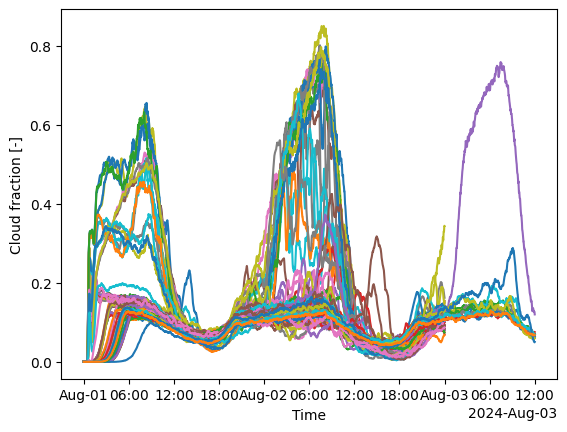

In [6]:
# Cloud-free solutions / Entirely cloudy solutions
ls=ds_tm['cfrac'].plot.line(x='time', add_legend=False)
# Looks good 

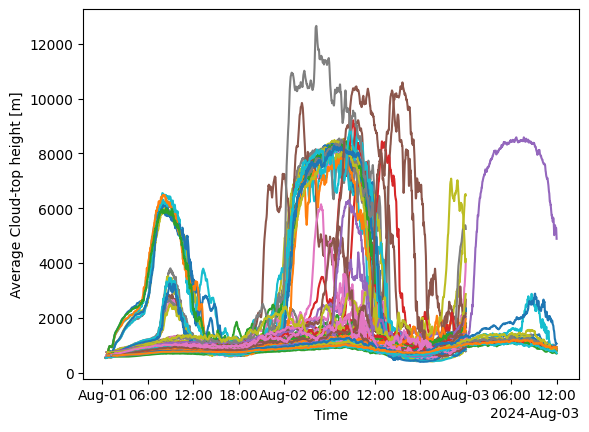

In [7]:
ls=ds_tm['zc_av'].plot.line(x='time', add_legend=False)

# Some cases are deep; some begin to develop only on the second night => Spin things up quicker if we start at sunset?

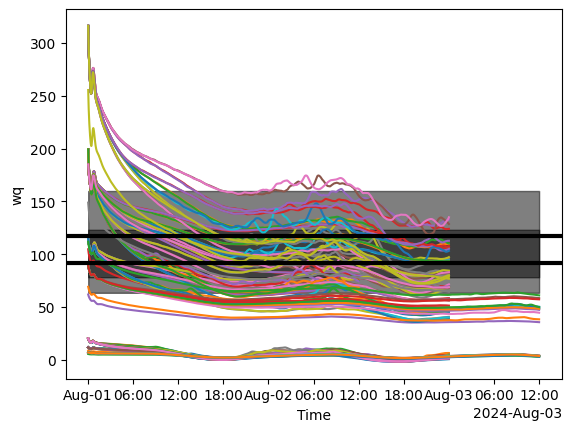

In [8]:
# Plot basic indicators
# Surface fluxes
cp=1004.
rho=1.225
Lv = 2.5e6

# Load ERA5
era5_dir = '/vol0500/data/hp240116/martin/deep-botany/deep-botany/data'
ds_e5s = xr.open_dataset(era5_dir+'/era5_ns_h-le.nc')

fig=plt.figure(); ax = plt.gca()
(cp*rho*ds_tm['wtheta']).plot.line(x='time', ax=ax, add_legend=False)
(Lv*ds_tm['wq']).plot.line(x='time', ax=ax, add_legend=False)

# ax.axhline(-ds_e5s['avg_slhtf'].mean(), c='k', lw=3)
# ax.axhline(-ds_e5s['avg_ishf'].mean(), c='k', lw=3)

# ls = (Lv*ds_tm['pr']).plot.line(x='time')
ds_e5ss = ds_e5s.sel(latitude=slice(10,5)).mean(['latitude','longitude'])
ds_e5sn = ds_e5s.sel(latitude=slice(15,10)).mean(['latitude','longitude'])

ax.axhline(-ds_e5ss['avg_slhtf'].mean().values, c='k', lw=3)
# ax.axhline(-ds_e5ss['avg_ishf'].mean(), c='k', lw=3)

ax.axhline(-ds_e5sn['avg_slhtf'].mean().values, c='k', lw=3)
# ax.axhline(-ds_e5sn['avg_ishf'].mean(), c='k', lw=3)

ax.fill_between(ds_tm.time, (-ds_e5ss['avg_slhtf']).quantile(0.1), (-ds_e5ss['avg_slhtf']).quantile(0.9), alpha=0.5, color='k')
ax.fill_between(ds_tm.time, (-ds_e5sn['avg_slhtf']).quantile(0.1), (-ds_e5sn['avg_slhtf']).quantile(0.9), alpha=0.5, color='k')

# These fluxes are still biased too low. Either
# - the SSTs are too low (but I don't think so, since we use the actual SSTs?) 
# - the surface winds are too low (i.e. the specified nudging/geostrophic wind is too small)
# - the ustar is too small


In [9]:
## 1D
profs = [dirs[i]+'/profiles.001.nc' for i in range(len(dirs))]
ds1 = xr.open_mfdataset(profs, combine='nested', concat_dim=member)

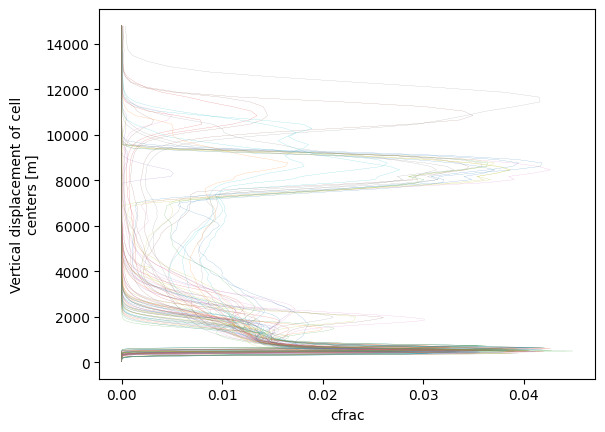

In [10]:
tmin = '2024-08-02 00:00:00'
tmax = '2024-08-02 12:00:00'

l=ds1['cfrac'].sel(time=slice(tmin,tmax), zt=slice(0,1.5e4)).mean('time').plot.line(y='zt', add_legend=False, lw=0.1)
# l=ds1['thv'].sel(time=slice(tmin,tmax), zt=slice(0,5e3)).mean('time').plot.line(y='zt', add_legend=False, lw=0.1)

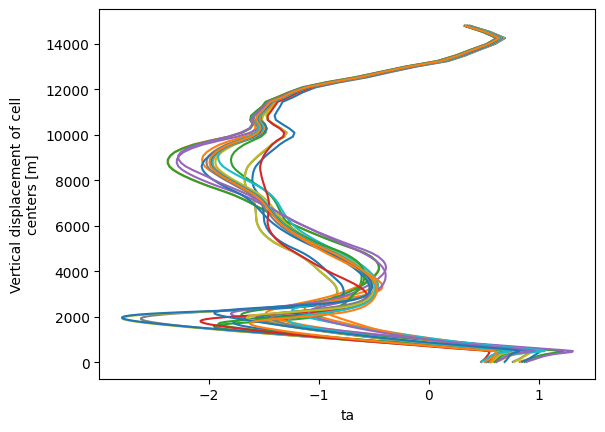

In [52]:
l=(ds1['ta'].sel(time='2024-08-04 00:00:00', method='nearest') - ds1['ta'].sel(time='2024-08-01 00:00:00', method='nearest')).sel(zt=slice(0,1.5e4)).plot.line(y='zt', add_legend=False)

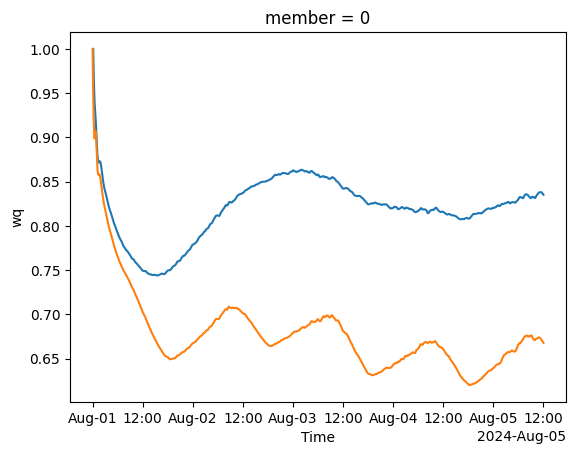

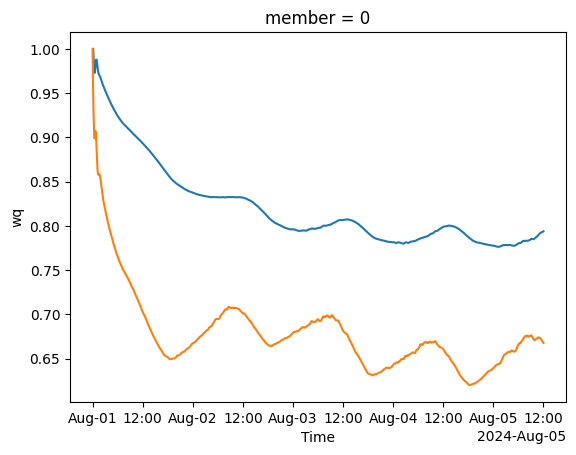

In [64]:
## 0D + 1D - why is the surface flux too low?
import thermo

# Can wind explain the drop (based on means)
U = np.sqrt(ds1['u']**2 + ds1['v']**2)
(U.sel(member=0, zt=20)/U.sel(member=0, zt=20).isel(time=0)).plot()
(ds_tm['wq'].sel(member=0)/ds_tm['wq'].sel(member=0).isel(time=0)).plot()
plt.show()

# Partially!

# Can mixed layer warming/moistening explain the drop
ps = 101300.
thls = 299.75
Ts = thls*(ps/1e5)**(2./7)
qs = thermo.qsatur(Ts, ps)

((qs-ds1['qt'].sel(member=0, zt=20))/(qs-ds1['qt'].sel(member=0, zt=20).isel(time=0))).plot()
(ds_tm['wq'].sel(member=0)/ds_tm['wq'].sel(member=0).isel(time=0)).plot()
plt.show()

# Also partially

In [55]:
# 2D
# Per condition
import copy

# exclude unmerged
dirs2 = [dirs[i] for i in range(len(dirs))]
dirs2.remove('/vol0500/data/hp240116/fredrik/deep-botany/ensemble/run_37')
dirs2.remove('/vol0500/data/hp240116/fredrik/deep-botany/ensemble/run_38')
dirs2.remove('/vol0500/data/hp240116/fredrik/deep-botany/ensemble/run_39')
dirs2.remove('/vol0500/data/hp240116/fredrik/deep-botany/ensemble/run_40')
dirs2.remove('/vol0500/data/hp240116/fredrik/deep-botany/ensemble/run_41')
dirs2.remove('/vol0500/data/hp240116/fredrik/deep-botany/ensemble/run_42')

labs2d = np.array(copy.deepcopy(labs))
labs2d = np.hstack((labs2d[:37],labs2d[43:]))

mem_2d = xr.DataArray(data=labs2d, coords={'member':np.array(labs2d)})

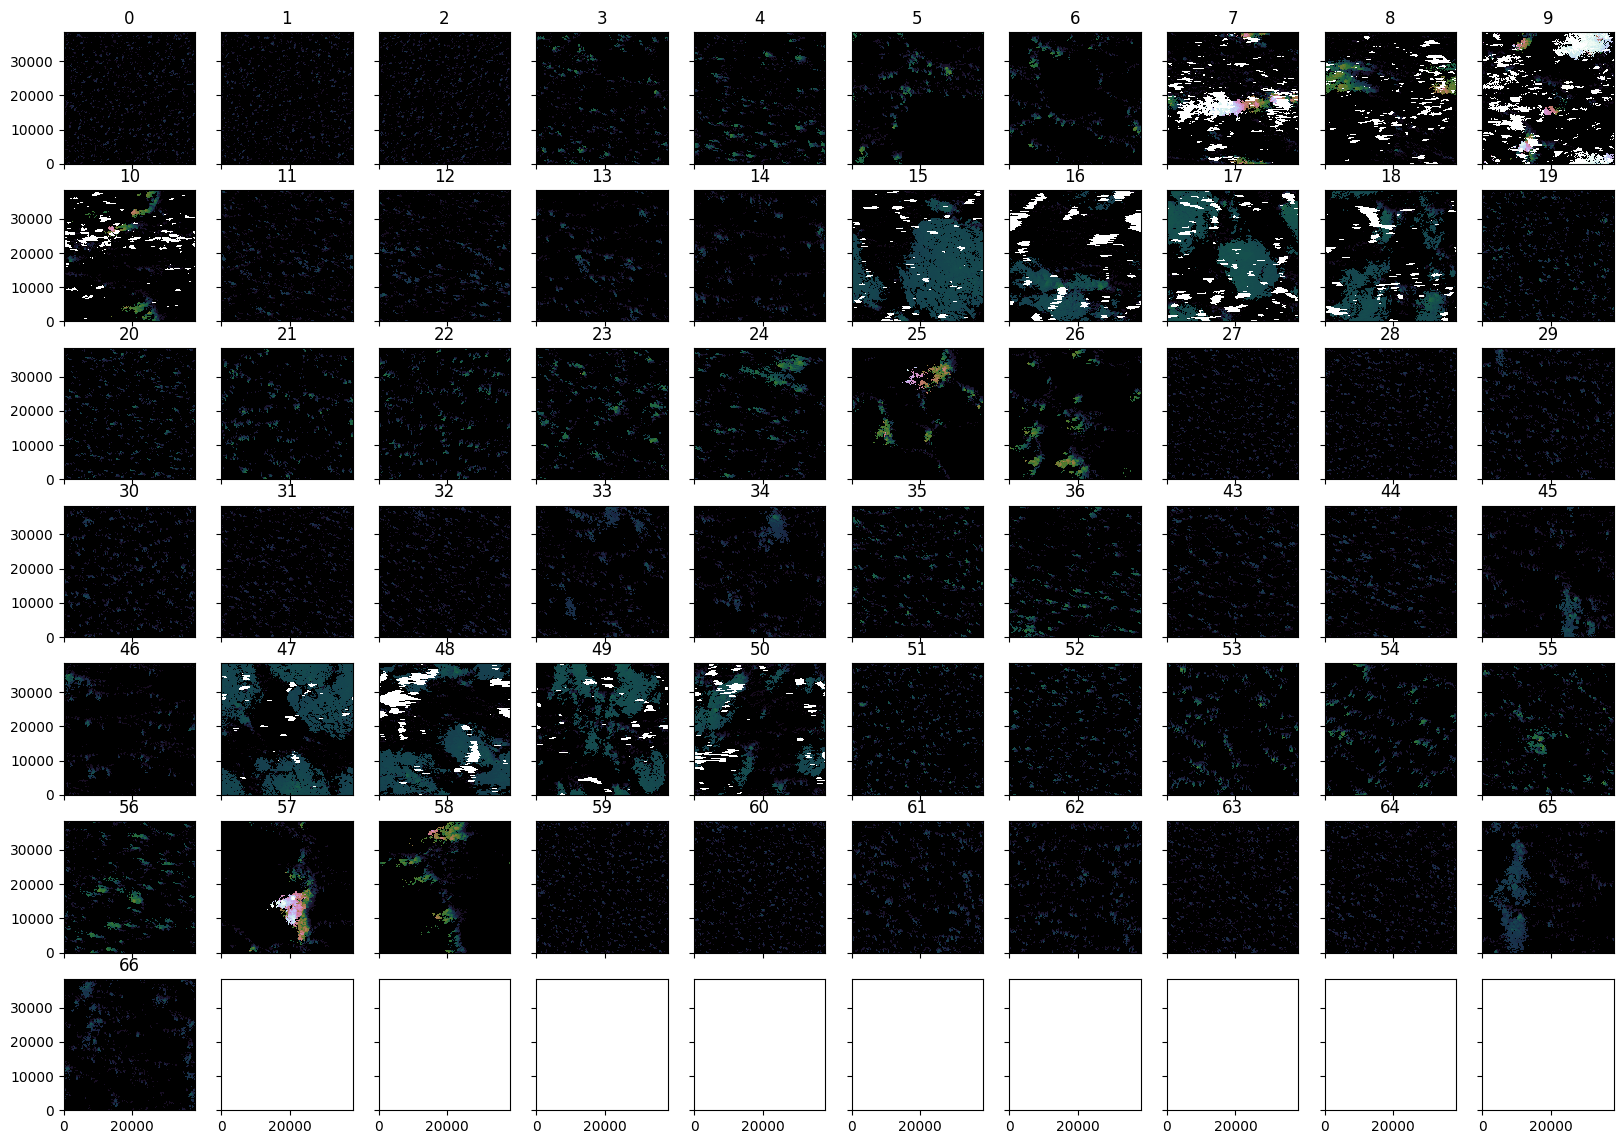

In [56]:
# cldtop
cldtops = [dirs2[i]+'/cape-cldtop.nc' for i in range(len(dirs2))]
dst = xr.open_mfdataset(cldtops, combine='nested', concat_dim=mem_2d)
dst

fig, axs = plt.subplots(ncols=10, nrows=7, figsize=(20,14), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(len(mem_2d)):
    dsti = dst.isel(member=i,time=-1)
    dsti['cldtop'].plot(vmin=0,vmax=7500,ax=axs[i], add_colorbar=False, cmap='cubehelix')
    axs[i].set_title(mem_2d[i].values)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

(0.0, 5e-05)

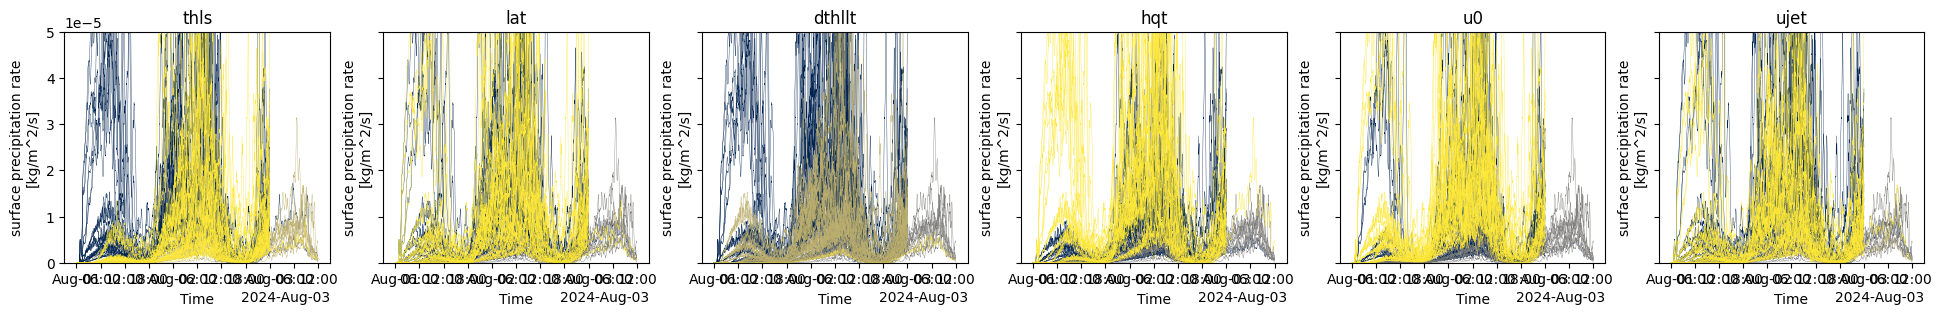

In [11]:
import matplotlib as mpl

# By condition
df_pars = pd.read_csv('/vol0500/data/hp240116/fredrik/deep-botany/ensemble-2/parameters.csv')
df_pars = df_pars.rename(columns={'Unnamed: 0':'member'})

ds_tm = ds_tm.assign(df_pars.set_index('member').to_xarray())

# Plot a variable at low, high and middle, for each varied condition
parvar = ['thls','lat','dthllt','hqt','u0','ujet']

varpl = 'wq'
varpl = 'pr'
# varpl = 'zc_av'
# varpl = 'cfrac'
# varpl = 'zc_max'

fig,axs = plt.subplots(ncols=len(parvar), figsize=(24,3), sharey=True)
for i in range(len(parvar)):
    dsv = ds_tm[[varpl,parvar[i]]].groupby(parvar[i])
    ax = axs[i]
    cmap = mpl.colormaps['cividis']
    colors = cmap(np.linspace(0, 1, len(dsv)))
    for j in range(len(dsv)):
        lj = list(dsv)[j]
        vj = lj[0]
        (lj[1][varpl]).plot.line(x='time',ax=axs[i],color=colors[j],add_legend=False,lw=0.25)
    ax.set_title(parvar[i])

plt.ylim(0,5e-5)

`wq`: The main knobs for the surface flux are the temperature and the wind, which we already knew. Maybe the dryness of the FT does make a small difference.
`wthetav`: Follows wq
`cfrac`: The super high cases *require* the moist FT point, the cold thls point and the stable FT. But even at a lower stability we get high cloud fractions.
`pr`: We get a little bit of rain from nearly all cases, on the second night. That is nice. Most important are hqt (is the dry case too dry?) and dthllt 

Takeaways (1):
- Make the moistest FT slightly less moist. Maybe also the dry case less dry => Very little rain
- Make the strongest dthllt less stable; they produce hardly any rain, clouds are trapped under an inversion, with little perpsective for further growth. This is a stratocumulus regime.
- lat seems to matter little; I am not sure it is worth a sweep
- We aren't necessarily interested in the most stable and dry corner of this cube. So make these corners less stable and dry!

Takeaways (2):
- Cold SST runs with low wind speeds, and unstable and moist FTs go deepest, give most cloud and generate most precip??
- Very little variability otherwise
- Swap latitude for moisture advection?
- Should worry about the many, many runs that stay in v/shallow cumulus regime

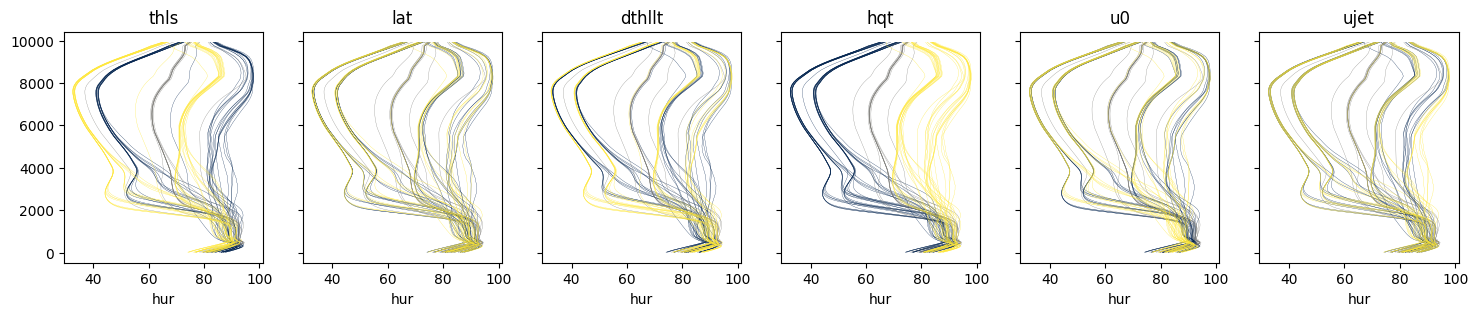

In [15]:
# Now 1D
tmin = '2024-08-02 00:00:00'
tmax = '2024-08-02 12:00:00'

ds1m = ds1.assign(df_pars.set_index('member').to_xarray()).sel(time=slice(tmin,tmax), member=slice(3,110)).mean('time')

varpl = 'wthvt'
varpl = 'cfrac'
varpl = 'hur'
# varpl = 'thv'
# varpl = 'qt2r'

fig,axs = plt.subplots(ncols=len(parvar), figsize=(18,3), sharey=True)
for i in range(len(parvar)):
    dsv = ds1m[[varpl,parvar[i]]].sel(zt=slice(0,10e3)).groupby(parvar[i])
    ax = axs[i]
    cmap = mpl.colormaps['cividis']
    colors = cmap(np.linspace(0, 1, len(dsv)))
    for j in range(len(dsv)):
        lj = list(dsv)[j]
        vj = lj[0]
        lj[1][varpl].plot.line(y='zt',ax=axs[i],color=colors[j],add_legend=False, lw=0.2)
        if j > 0:
            ax.set_ylabel('')
    ax.set_title(parvar[i])

Confirms that the big low cloud peaks are combinations of high stability, high moisture and low SST. That is, the higher SST point is able to break this.
Unstable cases seem to be needed to produce much deep cloud. Nothing (!) emerges from the high SST cases.
`w2r`, `wthvt`, `wqtt` all indicate little turbulence in the upper troposphere.
Most cases have little to no upper-level clouds. Those that do, are cases with low SST, low stability, high moisture and, somehow, low ujet (no/little shear).

=> Need to wait longer to be sure that this is not working as intended